## Imports

In [1]:
import os
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torchvision import datasets, transforms, models
from matplotlib import pyplot as plt
import pandas as pd
from PIL import Image
import numpy as np
import cv2

In [2]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## Data Loading & Preprocessing

In [3]:
train_folder = "/kaggle/input/real-and-fake-image-create-by-ai/MyDataset/train"
val_folder = "/kaggle/input/real-and-fake-image-create-by-ai/MyDataset/test"
epochs = 100
lr = 0.003

Prepare Datasets

Ela filter

In [12]:
class ELAFilter:
    def __init__(self, quality=90):
        self.quality = quality

    def __call__(self, img):
        # Convert torch tensor to numpy array (H, W, C) and scale to [0, 255]
        img_np = img.permute(1, 2, 0).numpy() * 255.0
        img_np = img_np.astype(np.uint8)

        # Save the image at the specified quality level
        _, compressed_image = cv2.imencode('.jpg', img_np, [int(cv2.IMWRITE_JPEG_QUALITY), self.quality])
        compressed_image = cv2.imdecode(compressed_image, 1)

        # Calculate the ELA image (absolute difference)
        ela_image = np.abs(img_np - compressed_image)

        # Normalize ELA to the range [0, 1]
        # ela_image = ela_image.astype(np.float32) / 255.0
        #print(ela_image)
        # Convert ELA back to torch tensor
        ela_tensor = torch.tensor(ela_image).permute(2, 0, 1).float()  # Convert to (C, H, W) and float type

        return ela_tensor

In [4]:
# Define transforms
transform_resnet = transforms.Compose([
    transforms.Resize(256),  # Resize to a size a bit larger than required, helps with random cropping
    transforms.CenterCrop(224),  # Center crop to the required size (224x224)
    transforms.ToTensor(),  # Convert to tensor
    ])
val_transform_resnet = transforms.Compose([
    transforms.Resize(256),  # Resize to a size a bit larger than required, helps with random cropping
    transforms.CenterCrop(224),  # Center crop to the required size (224x224)
    transforms.ToTensor(),  # Convert to tensor
   ])

# Load dataset
full_data = datasets.ImageFolder(root=train_folder, transform=transform_resnet)

val_data = datasets.ImageFolder(root=val_folder, transform=val_transform_resnet)

# Define train-test split ratio
train_size = int(0.7 * len(full_data))
test_size = len(full_data) - train_size

# Split the dataset
train_data, test_data = torch.utils.data.random_split(full_data, [train_size, test_size])

# Create DataLoader for each dataset
batch_size = 128
train_loader = DataLoader(train_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=False)
val_loader = DataLoader(val_data, batch_size, shuffle=False)

# Print number of samples in each split
print(f'Training samples: {len(train_data)}')
print(f'Testing samples: {len(test_data)}')

Training samples: 16859
Testing samples: 7226


In [5]:
print(full_data.classes)
print(val_data.classes)

['fake', 'real']
['fake', 'real']


testing dataloaders with 5 random photos

In [ ]:
i = 0
for i, (images, labels) in enumerate(train_loader, 0):  # Assuming train_loader gives a batch of images and labels
    if i >= 5:
        break
    
    # Access the first image in the batch and permute dimensions
    image = images[0].permute(1, 2, 0)
    
    # Display the image
    plt.imshow(image)
    plt.title("fake" if labels[0] == 0 else "real")
    plt.show()
    
    i += 1

## Training/Validation Methods

In [12]:
from tqdm import tqdm
import gc
# Training loop
def train_model(model, criterion, optimizer, dataloaders, classification_layer,finetuning_lr,num_epochs=10):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Use tqdm to wrap the dataloader
            phase_dataloader = tqdm(dataloaders[phase], desc=phase)
            for inputs, labels in phase_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device).float().unsqueeze(1)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward
                if phase == "train":
                    if epoch >= 0.8 * num_epochs:
                        # Unfreeze all layers for fine-tuning
                        for param in model.parameters():
                            param.requires_grad = True
                        optimizer.param_groups[0]['lr'] = finetuning_lr
                    else:
                        # Freeze the CNN part
                        for param in model.parameters():
                            param.requires_grad = False
                        # Unfreeze the classification layer
                        for param in classification_layer.parameters():
                            param.requires_grad = True
                elif phase == "val":
                    for param in model.parameters():
                            param.requires_grad = False

                        
                outputs = model(inputs)
                preds = torch.sigmoid(outputs)
                preds = (preds > 0.5).float()
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Clear cache after each epoch
            torch.cuda.empty_cache()
            del inputs, labels
            gc.collect()
        
        print()

    return model

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
from tqdm import tqdm

def test_model(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        val_dataloader = tqdm(dataloader, desc="validation")
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            

            preds = (torch.sigmoid(outputs) > 0.5) * 1
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            all_labels.append(labels)
            all_preds.append(preds)

    # Move all predictions and labels to CPU once
    all_labels = torch.cat(all_labels).cpu().numpy()
    all_preds = torch.cat(all_preds).cpu().numpy()

    epoch_loss = running_loss / len(dataloader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f'Test Loss: {epoch_loss:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    return epoch_loss, accuracy, precision, recall, f1


## Save/Load Methods

In [14]:
import datetime as dt
def save_model(model, model_name,model_evaluation_history):
    model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
    # Define the string date format.
    # Get the current Date and Time in a DateTime Object.
    # Convert the DateTime object to string according to the style mentioned in date_time_format string.
    date_time_format = '%Y_%m_%d__%H_%M_%S'
    current_date_time_dt = dt.datetime.now()
    current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

    # Define a useful name for our model to make it easy for us while navigating through multiple saved models.
    model_file_name = f'{model_name}___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.pth'

    # Save your Model.
    torch.save(model.state_dict(), f'{model_file_name}_entire_dict')
    torch.save(model, f'{model_file_name}_entire')

def load_model(model_path):
    # Load the object from the file
    loaded_model = torch.load(model_path)
    loaded_model.eval()
    
    return loaded_model

## Models Training

### **EfficientNet Training**

In [ ]:

model = efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
dataloaders = {'train' : train_loader, 'val' : test_loader}
device = "cuda"
# Modify the classifier to fit the binary classification problem
num_features = model.classifier.fc.in_features
model.classifier.fc = nn.Linear(num_features, 1)  # Output layer for binary classification

# Move the model to the appropriate device
model = model.to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy loss with logits
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = train_model(model, criterion, optimizer, dataloaders, model.classifier.fc ,10e-6)

epoch_loss, accuracy, precision, recall, f1 = test_model(model, val_loader, criterion, device)

save_model(model, "efficientnet-B0", (epoch_loss, accuracy))


### **ResNet Training**

In [ ]:
model = models.resnet50(pretrained=True)
# model = load_model("ResNet-50(NEW_DS)___Date_Time_2024_07_20__17_19_24___Loss_0___Accuracy_0.pth_entire")
dataloaders = {'train' : train_loader, 'val' : test_loader}
device = "cuda"
# Modify the classifier to fit the binary classification problem
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)  # Output layer for binary classification

# Move the model to the appropriate device
model = model.to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy loss with logits
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = train_model(model, criterion, optimizer, dataloaders,model.fc ,10e-6, num_epochs=10)

# epoch_loss, accuracy, precision, recall, f1 = test_model(model, val_loader, criterion, device)

save_model(model, "ResNet-50", (0, 0))

### **ResNext**

In [ ]:
# Define the dataloaders
dataloaders = {'train': train_loader, 'val': test_loader}

# Set device to GPU if available
device = torch.device("cuda")

# Load the ResNeXt model with pretrained weights
model = models.resnext50_32x4d(pretrained=True)

# Modify the classifier to fit the binary classification problem
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)  # Output layer for binary classification

# Move the model to the appropriate device
model = model.to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy loss with logits
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model = train_model(model, criterion, optimizer, dataloaders, model.fc, 10e-6, num_epochs=8)

save_model(model, "resnext50_32x4d", (0, 0))
epoch_loss, accuracy, precision, recall, f1 = test_model(model, val_loader, criterion, device)

### **VGG**

In [ ]:
# Define the dataloaders
dataloaders = {'train': train_loader, 'val': test_loader}

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the VGG model with pretrained weights
model = models.vgg16(pretrained=True)

# Modify the classifier to fit the binary classification problem
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 1)  # Output layer for binary classification

# Move the model to the appropriate device
model = model.to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy loss with logits
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = train_model(model, criterion, optimizer, dataloaders, model.classifier[6], 10e-6)

epoch_loss, accuracy, precision, recall, f1 = test_model(model, val_loader, criterion, device)

save_model(model, "vgg16", (epoch_loss, accuracy))

# **Output Visualization**

In [16]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.features = None

        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.features = output
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def get_cam_weights(self):
        return torch.mean(self.gradients, dim=(2, 3), keepdim=True)

    def generate_heatmap(self, features):
        weights = self.get_cam_weights()
        weighted_sum = (weights * features).sum(dim=1, keepdim=True)
        heatmap = weighted_sum.relu()
        heatmap = F.interpolate(heatmap, size=(224, 224), mode='bilinear', align_corners=False)
        heatmap = heatmap.squeeze().cpu().detach().numpy()
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
        return heatmap

    def __call__(self, img_tensor, target_class):
        self.model.zero_grad()
        output = self.model(img_tensor)
        pred = (torch.sigmoid(output) > 0.5) * 1
        print(pred.data)
        print("fake" if pred == 0 else "real")
        target = torch.zeros_like(output)
        target[0][target_class] = 1
        output.backward(gradient=target)
        heatmap = self.generate_heatmap(self.features)
        return heatmap

def overlay_heatmap(image, heatmap, alpha=0.6, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlayed_image = heatmap * alpha + np.array(image) * (1 - alpha)
    return np.uint8(overlayed_image)

def overlay_heatmap(image, heatmap, alpha=0.6, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlayed_image = heatmap * alpha + np.array(image) * (1 - alpha)
    return np.uint8(overlayed_image)

def preprocess_image(img_path):
    img = Image.open(img_path)
    img_tensor = val_transform_resnet(img).unsqueeze(0).to(device)
    img_tensor.requires_grad = True
    return img_tensor, img


def generate_gradcam(model, target_layer, img_path):
    # Preprocess image
    img_tensor, img = preprocess_image(img_path)

    # Initialize Grad-CAM
    grad_cam = GradCAM(model, target_layer)

    # Forward pass
    output = model(img_tensor)
    target_class = output.argmax().item()

    # Generate heatmap
    heatmap = grad_cam(img_tensor, target_class)

    # Superimpose heatmap on the original image
    img_np = np.array(img.resize((224, 224)))
    overlayed_img = overlay_heatmap(img_np, heatmap)

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(overlayed_img)
    plt.axis('off')
    plt.show()

tensor([[0]], device='cuda:0')
fake


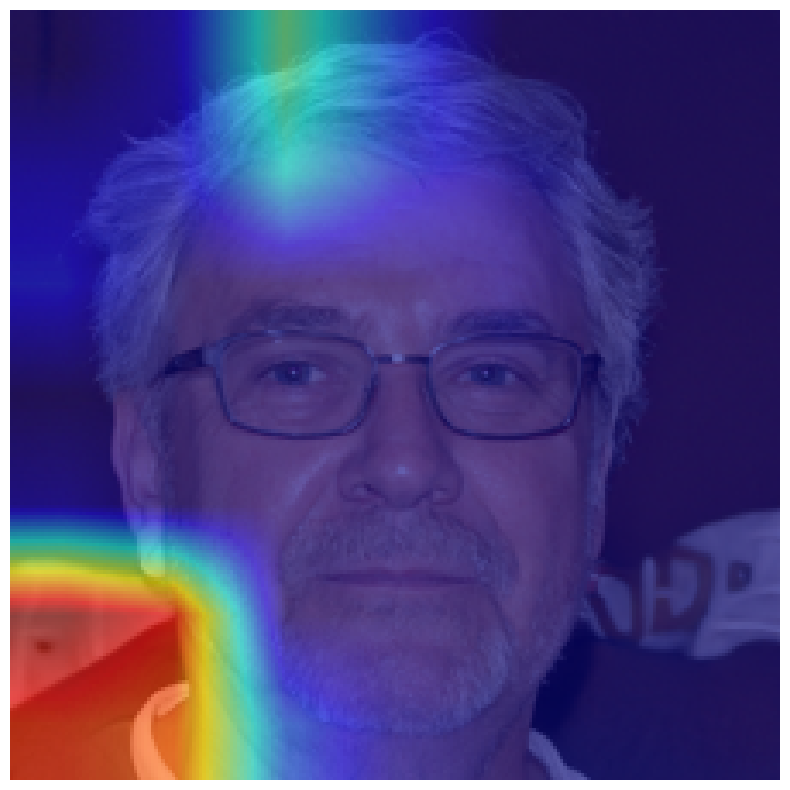

In [52]:
model = load_model("ResNet-50___Date_Time_2024_07_21__02_33_27___Loss_0___Accuracy_0.pth_entire")
target_layer = model.layer4[-1].conv3
img_path = '/kaggle/input/real-and-fake-image-create-by-ai/MyDataset/test/fake/20220902_153100_1a1a1616b7844c50bbbbc8a9638f2e35.png'

generate_gradcam(model, target_layer, img_path)